In [1]:
%matplotlib inline
import numpy as np
from numpy import pi

from scipy import signal
from scipy import sparse
from scipy import special
from scipy.optimize import *
from scipy.stats import vonmises

from sklearn.datasets import make_sparse_spd_matrix

import matplotlib.pyplot as plt

In [2]:
# LUT for Inverse Bessel function
N = 5000 
x = np.linspace(0,10,N)
y = special.iv(0,x) #modified Bessel function of first kind and order 0
LUT_IB = np.zeros([N,2])
LUT_IB[:,0] = y
LUT_IB[:,1] = x
del x, y, N

In [3]:
def InvBesselI0(y,LUT_IB):
    # assuming x is a scalar
    idx1 = np.nonzero(y > LUT_IB[:,0])[0]
    idx2 = np.nonzero(y < LUT_IB[:,0])[0]
    if len(idx1) == 0:
        z = LUT_IB[0,1]
    elif  len(idx2) == 0:
        z = LUT_IB[-1,1]
    else:
        # now do linear interpolation
        idx1 = idx1[-1]
        idx2 = idx2[0]
        y1 = LUT_IB[idx1,0]
        y2 = LUT_IB[idx2,0]
        z1 = LUT_IB[idx1,1]
        z2 = LUT_IB[idx2,1]
        z = z1 + (z2-z1)*(y-y1)/(y2-y1)
        
    return z

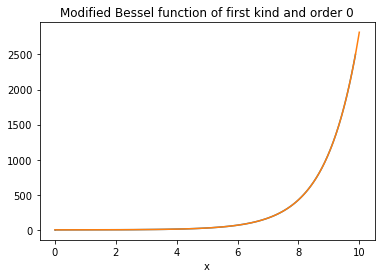

In [4]:
# check if inverse function works
y = np.linspace(0,2500,5000)
yinv = np.zeros([5000])
for k in range(5000):
    yinv[k] = InvBesselI0(y[k],LUT_IB)
    
plt.plot(yinv,y)
plt.plot(np.linspace(0,10,1000),special.iv(0,np.linspace(0,10,1000)))
plt.xlabel('x')
plt.title('Modified Bessel function of first kind and order 0')
plt.show()

In [5]:
# Function to compute the trigonometric moment Alpha0 

def Alpha0(a,b,l_ij,mu):
    # assuming the parameters are scalars
    x = np.linspace(-pi,pi,1000)
    dx = x[1] - x[0]
    k = np.abs(l_ij*np.sin(x - mu))
    return np.sum(np.exp(a*np.cos(x) + b*np.sin(x))*special.iv(0,k))*dx


Min eig value of K - L = 0.10855385812167295


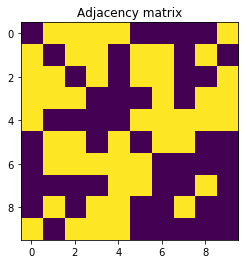

In [9]:
Nx = 10 # No. of variables

KVec = 1 + 2*np.random.rand(Nx) #concentration vector
MuVec = np.random.rand(Nx)*2*pi - pi #preferred orientations
MuVec = np.zeros(Nx)

LMat = 0.5*np.tril(sparse.random(Nx, Nx, density=0.6).A,-1)
LMat = LMat + LMat.T #interaction matrix

plt.imshow((LMat != 0)*1)
plt.title('Adjacency matrix')

# Check if K - L is positive definite
E = np.linalg.eigvals(np.diag(KVec) - LMat)
if min(E) < 0:
    KVec = KVec - min(E) + 0.1
    
print('Min eig value of K - L =',min(np.linalg.eigvals(np.diag(KVec) - LMat)))



In [10]:
# function for Von Mises EP

def VMEP(KVec, MuVec, LMat, lam):
    """
    Function that implements Expectation Propagation for a pairwise Von Mises graphical model
    using trigometric moment matching.
    Inputs:
        KVec:  concentration parameters
        MuVec: preferred orientations
        LMat:  interaction matrix
        lam:   relaxation for updates, between 0 and 1
   
    Outputs: 
        AVec: vector of marginal cosine natural parameters
        BVec: vector of marginal sine natural parameters
        AMat: time series of marginal cosine natural parameters
        BMat: time series of marginal sine natural parameters
    """
    
    N = KVec.shape[0]
    
    Ad = (LMat != 0)*1 #adjacency matrix 
    
    # initialize the parameters of the messages
    # MA[i,j] corresponds to cosine parameter of the message sent from node i to node j
    # MB[i,j] corresponds to sine parameter of the message sent from node i to node j
    
    MA    = np.zeros([N,N])
    MB    = np.zeros([N,N])
    
    MAnew = np.zeros([N,N])
    MBnew = np.zeros([N,N])
    
    T = 500 # max no. of iteration
    eps = 1e-6 #tolerance for convergence
    
    AVec = np.zeros([N])
    BVec = np.zeros([N])
    AMat = np.zeros([N,T+1])
    BMat = np.zeros([N,T+1])
    
    CostVec = np.zeros([T]) # cost is norm(m(t) - m(t-1))
    
    # Input natural parameters: Convert KVec and MuVec to Ainp and Binp
    Ainp = KVec*np.cos(MuVec)
    Binp = KVec*np.sin(MuVec)
    
    AMat[:,0] = Ainp
    BMat[:,0] = Binp
    
    for t in range(T):
        for i in range(N):
            for j in range(N):
                if Ad[i,j]:
                    # update parameters of message from i -> j
                    # 1. Multiply all the incoming messages to i, expect j->i
                    A = Ainp[i] + np.sum(MA[:,i]) - MA[j,i]
                    B  = Binp[i] + np.sum(MB[:,i]) - MB[j,i]
                    # 2. Find trigonometric moment alpha0
                    alpha0 = Alpha0(A,B,LMat[i,j],MuVec[i])
                    # 3. Compute new message parameters based on moment matching
                    Kij_new = InvBesselI0(alpha0,LUT_IB)
                    Muij_new = MuVec[j] - pi/2
                    # 4. Convert to natural parameters
                    MAnew[i,j] = (1-lam)*MA[i,j] + lam*Kij_new*np.cos(Muij_new)
                    MBnew[i,j] = (1-lam)*MB[i,j] + lam*Kij_new*np.sin(Muij_new)
          
        # now compute the beliefs
        AVec = Ainp + np.sum(MAnew,axis=0)
        BVec = Binp + np.sum(MBnew,axis=0)
        AMat[:,t+1] = 1*AVec
        BMat[:,t+1] = 1*BVec
        
        # Check if the messages have converged
        OldParams = np.concatenate([MA.flatten(), MB.flatten()])
        NewParams = np.concatenate([MAnew.flatten(), MBnew.flatten()])
        RMSE = np.linalg.norm(OldParams - NewParams)/np.sqrt(np.sum(Ad)) 
        CostVec[t] = RMSE
            
        MA = 1*MAnew
        MB = 1*MBnew 
        
        if  RMSE <= eps:
            print('Converged in', t, 'iterations')
            break
        
        
    return AVec, BVec, AMat[:,0:t+1], BMat[:,0:t+1], CostVec[0:t]

In [11]:
AVec, BVec, AMat, BMat, CostVec = VMEP(KVec, MuVec, LMat, 1)

Converged in 3 iterations


In [13]:
BMat

array([[  0.        , -20.36401115, -50.        , -50.        ],
       [  0.        , -25.02384897, -60.        , -60.        ],
       [  0.        , -25.00277627, -60.        , -60.        ],
       [  0.        , -26.25755762, -60.        , -60.        ],
       [  0.        , -25.94417308, -60.        , -60.        ],
       [  0.        , -19.80005789, -50.        , -50.        ],
       [  0.        , -19.08509357, -50.        , -50.        ],
       [  0.        , -12.39495108, -30.        , -30.        ],
       [  0.        , -15.49518685, -39.58773003, -40.        ],
       [  0.        , -16.11585893, -40.        , -40.        ]])

In [27]:
N = KVec.shape[0]
    
Ad = (LMat != 0)*1 #adjacency matrix 
    
# initialize the parameters of the messages
# MA[i,j] corresponds to cosine parameter of the message sent from node i to node j
# MB[i,j] corresponds to sine parameter of the message sent from node i to node j
    
MA    = np.zeros([N,N])
MB    = np.zeros([N,N])
    
MAnew = np.zeros([N,N])
MBnew = np.zeros([N,N])
    
T = 500 # max no. of iteration
eps = 1e-6 #tolerance for convergence
    
AVec = np.zeros([N])
BVec = np.zeros([N])
AMat = np.zeros([N,T+1])
BMat = np.zeros([N,T+1])
    
CostVec = np.zeros([T]) # cost is norm(m(t) - m(t-1))
    
# Input natural parameters: Convert KVec and MuVec to Ainp and Binp
Ainp = KVec*np.cos(MuVec)
Binp = KVec*np.sin(MuVec)
    
AMat[:,0] = Ainp
BMat[:,0] = Binp

In [30]:
i = 0; j = 2
lam = 1
A = Ainp[i] + np.sum(MA[:,i]) - MA[j,i]
B  = Binp[i] + np.sum(MB[:,i]) - MB[j,i]
alpha0 = Alpha0(A,B,LMat[i,j],MuVec[i])
Kij_new = InvBesselI0(alpha0,LUT_IB)
Muij_new = MuVec[j] - pi/2
MAnew[i,j] = (1-lam)*MA[i,j] + lam*Kij_new*np.cos(Muij_new)
MBnew[i,j] = (1-lam)*MB[i,j] + lam*Kij_new*np.sin(Muij_new)

In [20]:
def vonMisesPDF(x,scale):
    return vonmises.pdf(x,scale)

def vonMises2(x,amp,scale, theta):
    return amp*vonmises.pdf(x,scale, theta)

0.96130433188479


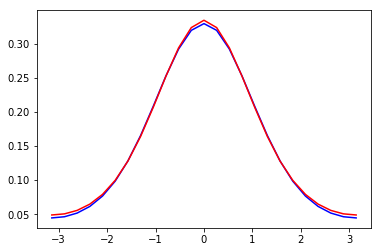

In [24]:
k1 = 1; k2 = 1; m1 = 0; m2 = 0; l = 0.5;
x = np.linspace(-pi,pi,25)
dx = x[1] - x[0]
Marg = special.iv(0,np.sqrt(k2**2 + (l*np.sin(x - m1))**2))*np.exp(k1*np.cos(x - m1))
Z = sum(Marg)*dx
Marg = Marg/Z

init_vals = [1] 
lb = [0]
ub = [10]
best_vals = curve_fit(vonMisesPDF, x-m1, Marg, p0=init_vals,bounds=(lb,ub))[0]
khat = best_vals[0]

plt.plot(x,Marg,'b')
plt.plot(x,vonmises.pdf(x-m1,khat),'r')

print(khat)

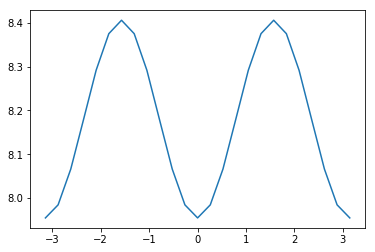

In [25]:
Msg = 2*pi*special.iv(0,np.sqrt(k2**2 + (l*np.sin(x - m1))**2))
plt.plot(x,Msg)

In [42]:
# init_vals = [1, 0] 
# lb = [0,-pi]
# ub = [10,pi]
# best_vals = curve_fit(vonMisesPDF, x, Marg, p0=init_vals,bounds=(lb,ub))[0]
# khat = best_vals[0]
# mhat = best_vals[1]

